In [7]:
from pathlib import Path

import polars as pl
import duckdb

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [19]:
SQL_ALL = """
SELECT *
FROM configurations
NATURAL JOIN metrics
NATURAL JOIN data_distributions
"""

def get_runid_from_file(filename: str) -> str:
    return filename.split(".")[0]

def single_col_to_list(results):
    return [row[0] for row in results]

def read_data(dbfile):
    conn = duckdb.connect(str(dbfile))
    logs = conn.sql(SQL_ALL)
    algorithms = single_col_to_list(conn.sql("SELECT DISTINCT algorithm FROM logs").fetchall())
    datasets = single_col_to_list(conn.sql("SELECT DISTINCT dataset FROM logs").fetchall())
    variables = single_col_to_list(conn.sql("SELECT DISTINCT variable FROM logs").fetchall())
    imbalance_types = single_col_to_list(conn.sql("SELECT DISTINCT imbalance_type FROM logs").fetchall())
    imbalance_values = single_col_to_list(conn.sql("SELECT DISTINCT imbalance_value FROM logs").fetchall())
    penalties = single_col_to_list(conn.sql("SELECT DISTINCT penalty FROM logs").fetchall())
    # sub_ids = single_col_to_list(conn.sql("SELECT DISTINCT sub_id FROM logs").fetchall())
    return conn, logs, algorithms, datasets, imbalance_types, imbalance_values, penalties

In [20]:
runfile = "/home/lukas/Work/Masterthesis/masterthesis-data/20240409_074752.db"

In [21]:
conn, logs, algorithms, datasets, imbalance_types, imbalance_values, penalties = read_data(Path(runfile))

# FedProx

In [22]:
fedprox = conn.sql("""
    PIVOT 
    (SELECT round, stage, variable, penalty, imbalance_value, avg(value) AS avg_value FROM logs
    WHERE
        dataset = 'cifar10'
        AND imbalance_type = 'label_distribution'
        AND algorithm IN ('FedProx', 'FedAvg')
    GROUP BY round, variable, stage, penalty, imbalance_value)
    ON variable
    USING first(avg_value)
    ORDER BY round, penalty
""")
fedprox_train = conn.sql("SELECT * FROM fedprox WHERE stage = 'train'").pl()
fedprox_test = conn.sql("SELECT * FROM fedprox WHERE stage = 'test'").pl()

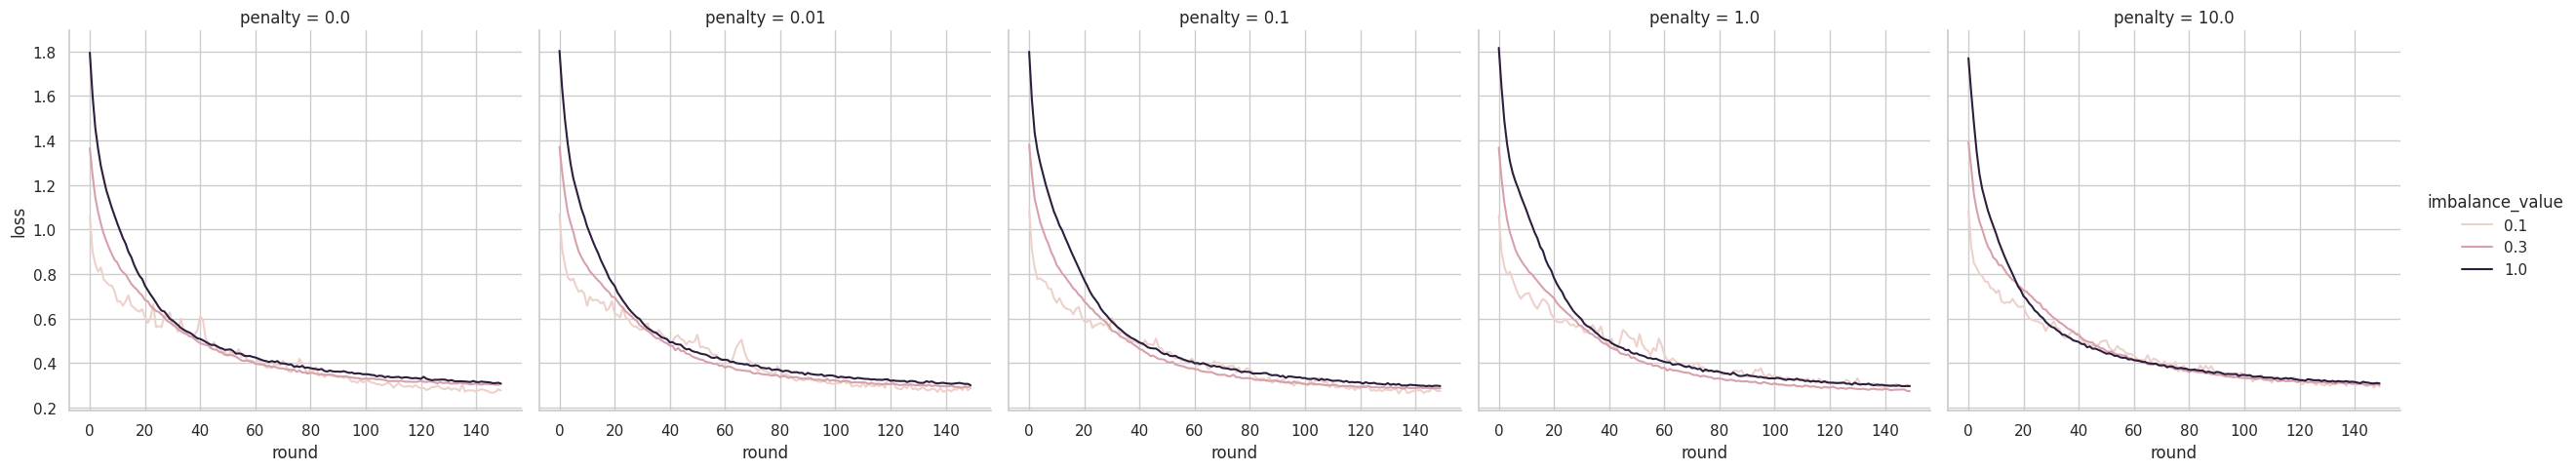

In [28]:
sns.relplot(fedprox_train, x="round", y="loss", hue="imbalance_value", col="penalty", kind="line")

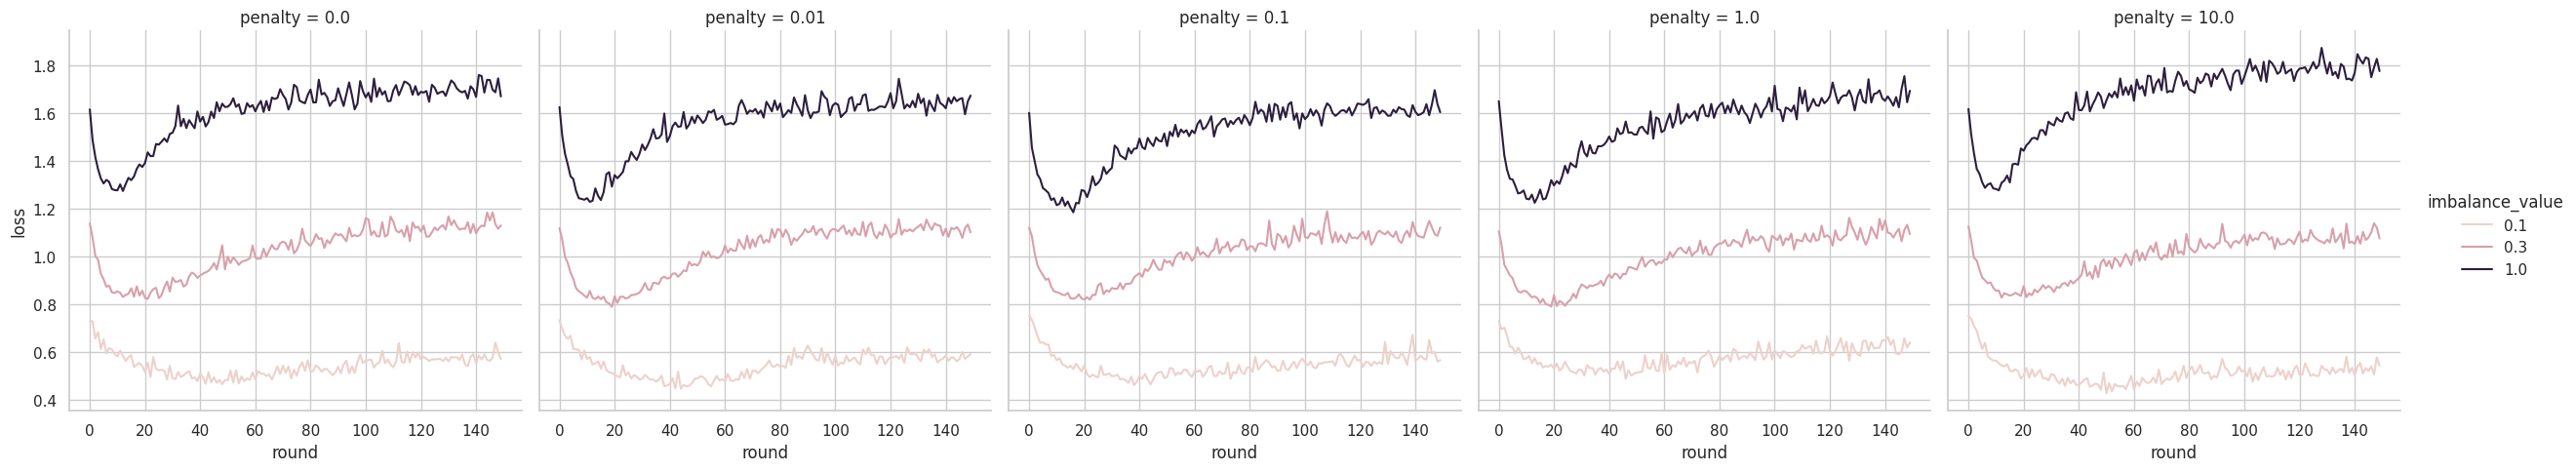

In [30]:
sns.relplot(fedprox_test, x="round", y="loss", hue="imbalance_value", col="penalty", kind="line")

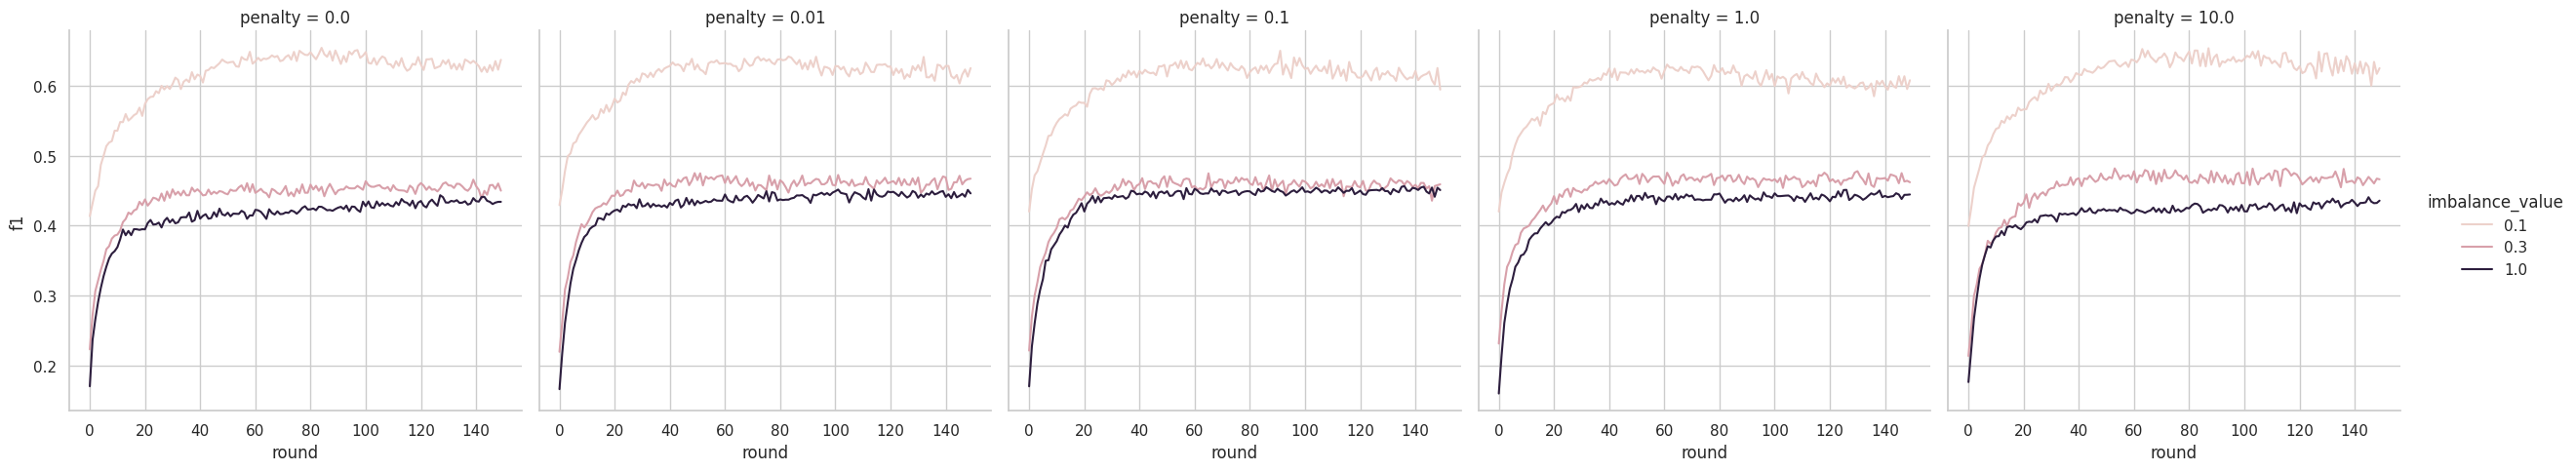

In [31]:
sns.relplot(fedprox_test, x="round", y="f1", hue="imbalance_value", col="penalty", kind="line")